<a href="https://colab.research.google.com/github/airctic/mantisshrimp/blob/master/notebooks/dataset_voc_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train a voc compatible dataset.
> Note: This notebook shows a special use case of training a VOC compatible dataset using the predefined [VOC parser](https://github.com/airctic/mantisshrimp/blob/master/mantisshrimp/parsers/voc_parser.py) without creating both data, and parsers files as opposed to the [fridge dataset](https://github.com/airctic/mantisshrimp/tree/master/mantisshrimp/datasets/fridge) example.

## Installing Mantisshrimp

We will install the Mantisshrimp latest version from its GitHub repo (master branch) 

In [ ]:
pip install git+git://github.com/airctic/mantisshrimp.git#egg=mantisshrimp[all] --upgrade

## Clone the raccoom dataset repository

In [ ]:
!git clone https://github.com/datitran/raccoon_dataset

## Imports

In [7]:
from mantisshrimp.all import *

## WARNING: 
Make sure you have already cloned the raccoon dataset using the command shown here above
### Set images and annotations directories

In [8]:
data_dir = Path('raccoon_dataset')

images_dir = data_dir / 'images'
annotations_dir = data_dir / 'annotations'

### Define class_map

In [9]:
class_map = ClassMap(['raccoon'])

### Parser: Use mantisshrimp predefined VOC parser

In [10]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

### train and validation records

In [ ]:
data_splitter = RandomSplitter((.8, .2))
train_records, valid_records = parser.parse(data_splitter)

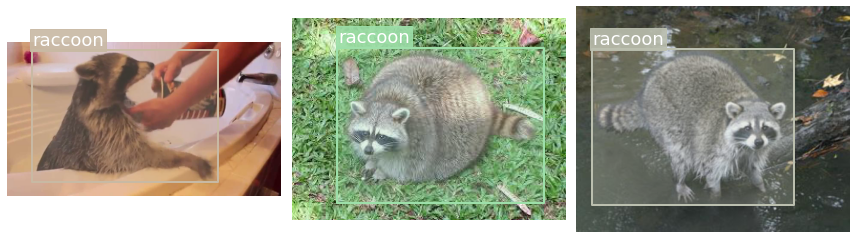

In [12]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Datasets
### Transforms

In [13]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

### Train and Validation Dataset Objects

In [14]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

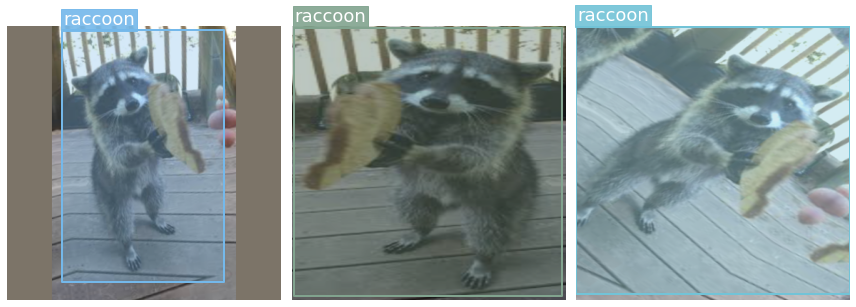

In [15]:
samples = [train_ds[5] for _ in range(3)]
show_samples(samples, class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

### DataLoaders

In [16]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

### Model

In [ ]:
model = efficientdet.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)

### Fastai Learner

In [18]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [19]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Fastai Training
### Learning Rate Finder

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

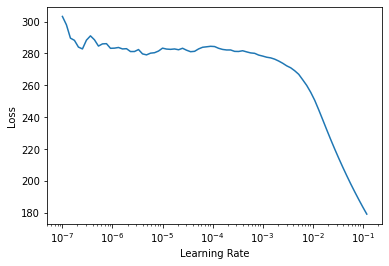

In [20]:
learn.freeze()
learn.lr_find()

### Fine tune: 2 Phases
- Phase 1: Train the head for 10 epochs while freezing the body
- Phase 2: Train both the body and the head during 50 epochs

In [ ]:
learn.fine_tune(50, 1e-2, freeze_epochs=10)

## Inference

In [ ]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=16)
samples, preds = efficientdet.predict_dl(model, infer_dl)

In [23]:
imgs = [sample['img'] for sample in samples]

### Show some samples

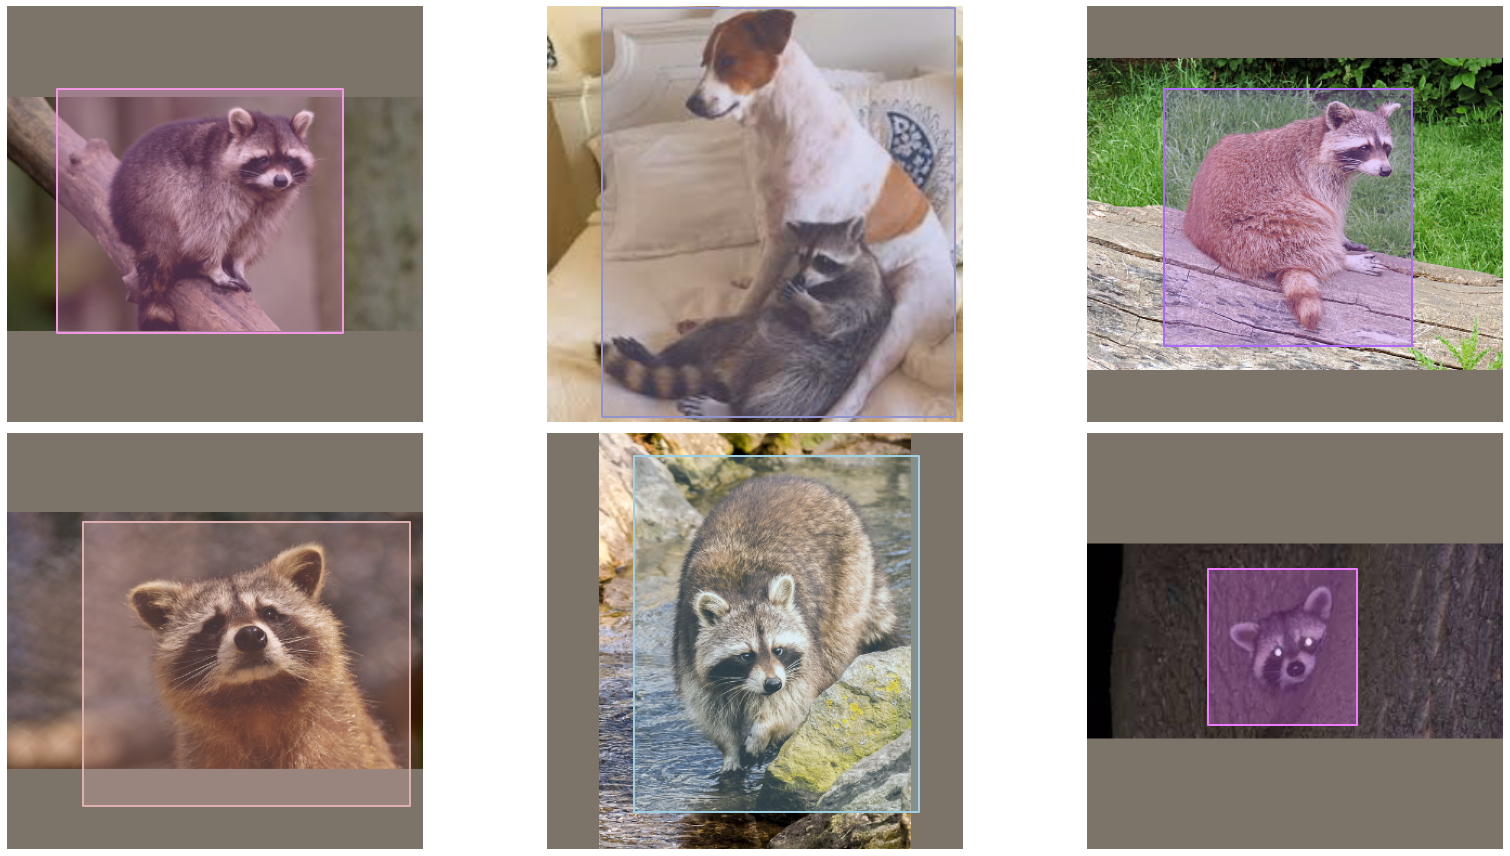

In [24]:
show_preds(imgs[:6], preds[:6], denormalize_fn=denormalize_imagenet, ncols=3, label=False)

> **Note:** You might train the model longer in order to increase its accuracy

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://spectrum.chat/mantis).